Random Forest Mean Squared Error: 0.0010


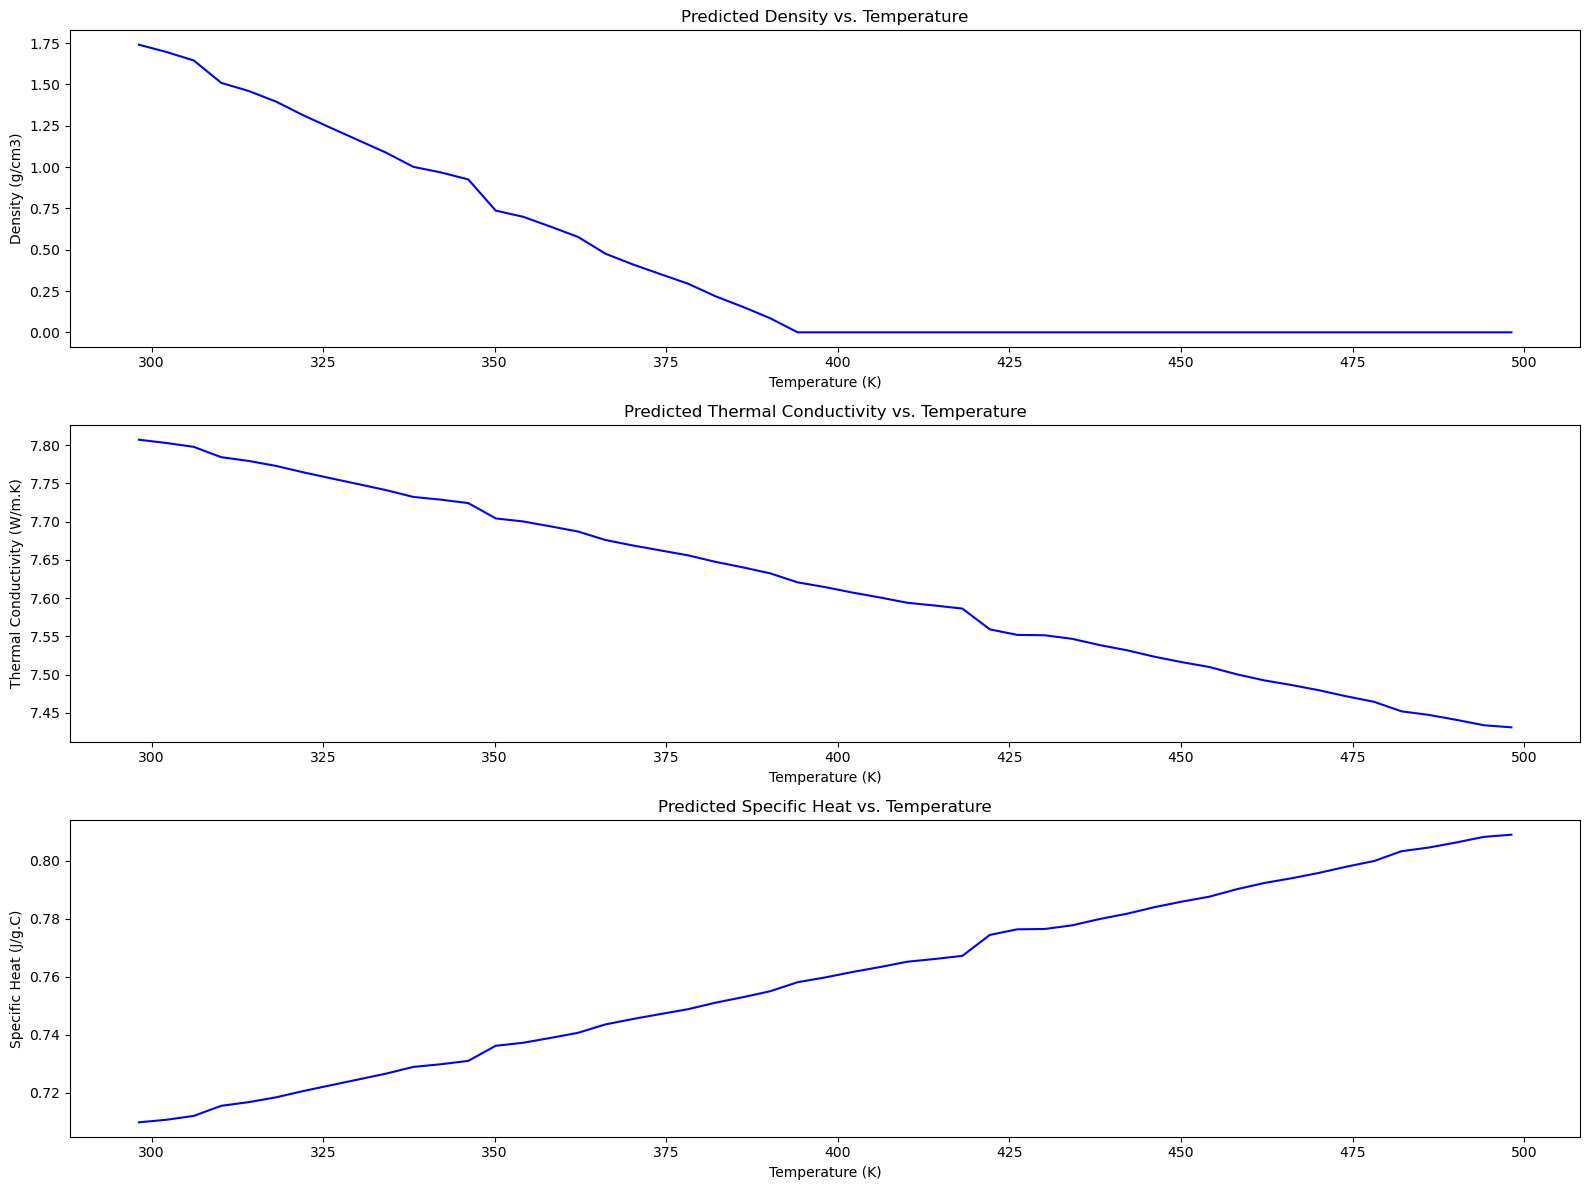

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load data from the Excel file
file_path = r"D:\Armaghan_PhD_Dissertation\database\Revised data\sajjad.xlsx"
ti_data = pd.read_excel(file_path, sheet_name='Ti')
o2_data = pd.read_excel(file_path, sheet_name='O2')

# Function to normalize only the density feature
def normalize_density(df):
    scaler = StandardScaler()
    df_normalized = df.copy()
    df_normalized[['Density (g/cm3)']] = scaler.fit_transform(df[['Density (g/cm3)']])
    return df_normalized, scaler

# Function to prepare and filter data based on temperature
def get_data_by_temperature(df, temperature):
    return df[df['T (K)'] == temperature]

# Function to combine data from two sheets and prepare the dataset
def combine_data(temp, ti_data, o2_data):
    ti_temp_data = get_data_by_temperature(ti_data, temp)
    o2_temp_data = get_data_by_temperature(o2_data, temp)
    if ti_temp_data.empty or o2_temp_data.empty:
        print(f"No data available for temperature {temp} in one or both sheets.")
        return None
    combined_data = pd.DataFrame({
        'T (K)': ti_temp_data['T (K)'],
        'Density_Ti': ti_temp_data['Density (g/cm3)'].values,
        'Density_O2': o2_temp_data['Density (g/cm3)'].values,
        'Thermal_Conductivity_Ti': ti_temp_data['Thermal Conductivity (W/m.K)'].values,
        'Thermal_Conductivity_O2': o2_temp_data['Thermal Conductivity (W/m.K)'].values,
        'Specific_Heat_Ti': ti_temp_data['Specific Heat (J/g.C)'].values,
        'Specific_Heat_O2': o2_temp_data['Specific Heat (J/g.C)'].values
    })
    combined_data['Density_combined'] = (combined_data['Density_Ti'] + combined_data['Density_O2']) / 2
    combined_data['Thermal_Conductivity_combined'] = (combined_data['Thermal_Conductivity_Ti'] + combined_data['Thermal_Conductivity_O2']) / 2
    combined_data['Specific_Heat_combined'] = (combined_data['Specific_Heat_Ti'] + combined_data['Specific_Heat_O2']) / 2
    return combined_data

# Function to create features and target variables
def create_features_and_targets(combined_data):
    features = combined_data[['T (K)', 'Density_Ti', 'Density_O2', 'Thermal_Conductivity_Ti', 'Thermal_Conductivity_O2', 'Specific_Heat_Ti', 'Specific_Heat_O2']]
    targets = combined_data[['Density_combined', 'Thermal_Conductivity_combined', 'Specific_Heat_combined']]
    return features, targets

# Function to train the Random Forest model
def train_random_forest(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X[['T (K)', 'Density_Ti', 'Density_O2']])
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    print(f"Random Forest Mean Squared Error: {mse_rf:.4f}")
    return rf_model, scaler

# Function to predict properties across all temperatures using Random Forest
def predict_properties_rf_all(ti_data, o2_data):
    ti_data_normalized, _ = normalize_density(ti_data)
    o2_data_normalized, _ = normalize_density(o2_data)

    combined_data_all = pd.DataFrame()

    for temp in ti_data['T (K)'].unique():
        combined_data = combine_data(temp, ti_data_normalized, o2_data_normalized)
        if combined_data is not None:
            combined_data_all = pd.concat([combined_data_all, combined_data], ignore_index=True)

    X, y = create_features_and_targets(combined_data_all)
    rf_model, scaler = train_random_forest(X, y)
    X_scaled = scaler.transform(X[['T (K)', 'Density_Ti', 'Density_O2']])
    predictions_rf = rf_model.predict(X_scaled)
    predictions_rf = np.maximum(predictions_rf, 1e-5)
    
    # Plotting the results
    plt.figure(figsize=(16, 12))

    plt.subplot(3, 1, 1)
    plt.plot(combined_data_all['T (K)'], predictions_rf[:, 0], color='blue')
    plt.title('Predicted Density vs. Temperature')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Density (g/cm3)')
    plt.grid(False)
    plt.gca().set_facecolor('white')

    plt.subplot(3, 1, 2)
    plt.plot(combined_data_all['T (K)'], predictions_rf[:, 1], color='blue')
    plt.title('Predicted Thermal Conductivity vs. Temperature')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Thermal Conductivity (W/m.K)')
    plt.grid(False)
    plt.gca().set_facecolor('white')

    plt.subplot(3, 1, 3)
    plt.plot(combined_data_all['T (K)'], predictions_rf[:, 2], color='blue')
    plt.title('Predicted Specific Heat vs. Temperature')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Specific Heat (J/g.C)')
    plt.grid(False)
    plt.gca().set_facecolor('white')

    plt.tight_layout()
    plt.show()

# Plot results for all temperatures
predict_properties_rf_all(ti_data, o2_data)
